## Introduction
in this analysis we explore the types of films doing best at the box office.We are to translate this findings into actionable insights that the new movie studio can use to help decide what type of films to create.Our analysis includes exploratory data analysis(EDA),statistical tests, regresion modelling and evaluation of model performance to draw meaningful conclusions and provide actionable recommendations

### Objectives
1. Identify which genres are well performing both domestically and internationally
2. Which movie studios consistently produce the most successful films
3. Analyze relationship between production budget and domestic and foreign gross 
4. Analyze trends over time
5. Analyze how a film’s popularity score and average rating affect film performance 
6. film performs better based on length(short_mid_long) - dentify if there is an ideal runtime for films that perform well at the box office.Group runtimes into intervals (e.g., 90–120 mins, 120–150 mins) to see if certain ranges perform better in terms of revenue.

### 1a)importing libraries


In [246]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import statsmodels.api as sm

### b)Reading the dataset from the csv file

In [107]:
#read the data from the csv,tsv file and create a dataframe to be used
movie_gross = pd.read_csv('../data/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('../data/rt.movie_info.tsv.gz',delimiter='\t')
movie_reviews = pd.read_csv('../data/rt.reviews.tsv.gz',delimiter='\t',encoding='latin-1')
movies = pd.read_csv('../data/tmdb.movies.csv.gz',index_col=0)
movie_budget = pd.read_csv('../data/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('../data/im.db')

### c)previewing our dataset

In [108]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.00,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.00,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.00,664300000,2010
3,Inception,WB,292600000.00,535700000,2010
4,Shrek Forever After,P/DW,238700000.00,513900000,2010


In [109]:
movie_info.head()
# movie_info.runtime.str.strip('minutes').fillna(0).astype(int).plot(kind='hist',figsize=(12,8),bins=20)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [110]:
movie_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [111]:
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [112]:
movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73,2010-03-26,How to Train Your Dragon,7.70,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.52,2010-05-07,Iron Man 2,6.80,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.00,1995-11-22,Toy Story,7.90,10174
4,"[28, 878, 12]",27205,en,Inception,27.92,2010-07-16,Inception,8.30,22186


In [113]:
#checking tables in our sqlite database
q = '''select * from sqlite_master'''
pd.read_sql(q,conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [114]:
q = '''select * from movie_ratings	'''
movie_ratings = pd.read_sql(q,conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


In [115]:
q = '''select * from movie_basics	'''
movie_basics = pd.read_sql(q,conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"


In [116]:
q = '''select * from movie_akas	'''
movie_akas= pd.read_sql(q,conn)
movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.00
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.00
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.00
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.00
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.00


### d)Accessing information about our datasets

In [117]:
###movie gross
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [118]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [119]:
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [120]:
movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [121]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [122]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [123]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [124]:
movie_akas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


### e)Accessing summary statistics about our data

In [125]:
#movie_gross
pd.set_option('display.float_format','{:.2f}'.format) 
movie_gross.describe()

,domestic_gross,year
count,3359.00,3387.00
mean,28745845.07,2013.96
std,66982498.24,2.48
min,100.00,2010.00
25%,120000.00,2012.00
50%,1400000.00,2014.00
75%,27900000.00,2016.00
max,936700000.00,2018.00


In [126]:
movie_gross.describe(include='O')

,title,studio,foreign_gross
count,3387,3382,2037
unique,3386,257,1204
top,Bluebeard,IFC,1200000
freq,2,166,23


In [127]:
#movie_info
movie_info.describe(include='O')

,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
count,1498,1557,1552,1361,1111,1201,1201,340,340,1530,494
unique,1497,6,299,1125,1069,1025,717,1,336,142,200
top,A group of air crash survivors are stranded in...,R,Drama,Steven Spielberg,Woody Allen,"Jan 1, 1987","Jun 1, 2004",$,"600,000",90 minutes,Universal Pictures
freq,2,521,151,10,4,8,11,340,2,72,35


In [128]:
movie_reviews.describe(include='O')

,review,rating,fresh,critic,publisher,date
count,48869,40915,54432,51710,54123,54432
unique,48682,186,2,3496,1281,5963
top,Parental Content Review,3/5,fresh,Emanuel Levy,eFilmCritic.com,"January 1, 2000"
freq,24,4327,33035,595,673,4303


In [129]:
movie_budget.describe(include='O')

,release_date,movie,production_budget,domestic_gross,worldwide_gross
count,5782,5782,5782,5782,5782
unique,2418,5698,509,5164,5356
top,"Dec 31, 2014",Halloween,"$20,000,000",$0,$0
freq,24,3,231,548,367


In [130]:
movies.describe()

,id,popularity,vote_average,vote_count
count,26517.00,26517.00,26517.00,26517.00
mean,295050.15,3.13,5.99,194.22
std,153661.62,4.36,1.85,960.96
min,27.00,0.60,0.00,1.00
25%,157851.00,0.60,5.00,2.00
50%,309581.00,1.37,6.00,5.00
75%,419542.00,3.69,7.00,28.00
max,608444.00,80.77,10.00,22186.00


In [131]:
#movie_basics
movie_basics.describe()

,start_year,runtime_minutes
count,146144.00,114405.00
mean,2014.62,86.19
std,2.73,166.36
min,2010.00,1.00
25%,2012.00,70.00
50%,2015.00,87.00
75%,2017.00,99.00
max,2115.00,51420.00


In [132]:
movie_basics.describe(include='O')

,movie_id,primary_title,original_title,genres
count,146144,146144,146123,140736
unique,146144,136071,137773,1085
top,tt0063540,Home,Broken,Documentary
freq,1,24,19,32185


In [133]:
#movie_ratings
movie_ratings.describe()

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


In [134]:
movie_akas.describe(include='O')

,movie_id,title,region,language,types,attributes
count,331703,331703,278410,41715,168447,14925
unique,122302,252781,213,76,10,77
top,tt2488496,Robin Hood,US,en,imdbDisplay,new title
freq,61,32,51490,22895,100461,1700


### 2.Cleaning our datasets
performing data cleaning procedures below providing a documentation for our action and reasons.Will perform as many data cleaning procedures as we think suitable for the various dimensions of data

In [135]:
#lets do a copy of our datasets first
df_movie_gross = movie_gross.copy()
df_movie_info = movie_info.copy()
df_movie_reviews = movie_reviews.copy()
df_movie_budget = movie_budget.copy()
df_movies = movies.copy()
df_movie_basics= movie_basics.copy()
df_movie_ratings= movie_ratings.copy()
df_movie_akas = movie_akas.copy()

In [136]:
df_movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.00,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.00,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.00,664300000,2010
3,Inception,WB,292600000.00,535700000,2010
4,Shrek Forever After,P/DW,238700000.00,513900000,2010


In [137]:
df_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [138]:
df_movie_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [139]:
df_movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [140]:
df_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73,2010-03-26,How to Train Your Dragon,7.70,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.52,2010-05-07,Iron Man 2,6.80,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.00,1995-11-22,Toy Story,7.90,10174
4,"[28, 878, 12]",27205,en,Inception,27.92,2010-07-16,Inception,8.30,22186


In [141]:
df_movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"


In [142]:
df_movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21


In [143]:
df_movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.00
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.00
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.00
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.00
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.00


### a)Check for missing values
1. movie_gross table

In [144]:
#1. movie_gross table
df_movie_gross.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [145]:
#studio column #drop missing values since the missing values are few
df_movie_gross.dropna(subset='studio',inplace=True)

In [146]:
#domestic_gross column
print(df_movie_gross['domestic_gross'].isna().value_counts(normalize=True)) #drop since missing values is just 0.01%
df_movie_gross.dropna(subset='domestic_gross',inplace=True)

False   0.99
True    0.01
Name: domestic_gross, dtype: float64


In [147]:
#foreign_gross column
df_movie_gross['foreign_gross'].isna().value_counts(normalize=True)

False   0.60
True    0.40
Name: foreign_gross, dtype: float64

In [148]:
#comvert foreign_gross to numeric
df_movie_gross['foreign_gross'] = df_movie_gross['foreign_gross'].str.replace(',','') #remove comma that was bringing errors in conversion
df_movie_gross['foreign_gross'] = pd.to_numeric(df_movie_gross['foreign_gross'])

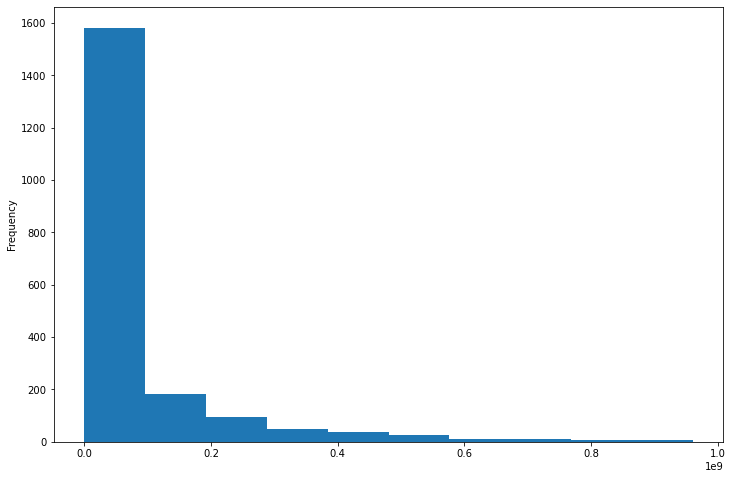

In [149]:
#data is postively skewed, will replace with median
df_movie_gross['foreign_gross'].plot(kind='hist',figsize=(12,8));
movie_gross_foreign_median  = df_movie_gross['foreign_gross'].median()
df_movie_gross['foreign_gross'].fillna(movie_gross_foreign_median,inplace=True)

In [150]:
df_movie_gross.isna().sum() #no missing values for our table

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

2. movie_info table

In [151]:
df_movie_info = df_movie_info[['id','genre','runtime','studio']]  #only need id,genre,runtime and studio columns
df_movie_info.isna().sum()

id            0
genre         8
runtime      30
studio     1066
dtype: int64

In [152]:
#drop  missing rows in genre since they are few
df_movie_info.dropna(subset='genre',inplace=True)

In [153]:
#runtime column
df_movie_info.runtime.isna().value_counts(normalize=True) #since its 2 % missing i will drop the data
df_movie_info.dropna(subset='runtime',inplace=True)

In [154]:
#clean up the runtime column once and for all by convering runtime to int
df_movie_info['runtime'] = df_movie_info['runtime'].str.strip('minutes').astype(np.int64)

In [155]:
#rename column  to runtime_minutes
df_movie_info.rename(columns={
                     'runtime' : 'runtime_minutes'
},inplace=True)

In [156]:
#studio column
df_movie_info['studio'].isna().value_counts(normalize=True) #len(df_movie_info[df_movie_info['studio'].isna()])/len(df_movie_info) # 68 percent of data missing,replace with not available since its a useful column for our analysis

True    0.68
False   0.32
Name: studio, dtype: float64

In [157]:
df_movie_info['studio'].fillna('UNKOWN',inplace=True)

In [158]:
df_movie_info.isna().sum() # no missing values for our table

id                 0
genre              0
runtime_minutes    0
studio             0
dtype: int64

3.movie_reviews table

In [159]:
df_movie_reviews.isna().sum() #no missing values

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

In [160]:
df_movie_reviews['rating'].value_counts().head(10) #do away with this table since rating values are not consistent

3/5      4327
4/5      3672
3/4      3577
2/5      3160
2/4      2712
2.5/4    2381
3.5/4    1777
3.5/5    1289
5/5      1237
B        1163
Name: rating, dtype: int64

4.movie_budget table

In [161]:
df_movie_budget.isna().sum() #no NA

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

5.movies table

In [162]:
df_movies.isna().sum() #no NA

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

### b)All missing values cleaned, let check for duplicates

In [163]:
print(df_movie_gross.duplicated().sum()) #0 duplicates
print(df_movie_info.duplicated().sum()) #0 duplicates
print(df_movie_budget.duplicated().sum())#0 duplicates
# print(df_movie_reviews.duplicated().sum()) # 9 duplicates- dont need this table per now unless otherwise
print(df_movies.duplicated().sum()) #1020 duplicates

0
0
0
1020


In [164]:
#check duplicated values in moviws table
df_movies[df_movies.duplicated(keep=False)].sort_values('id')
#drop duplicates
df_movies.drop_duplicates(inplace=True)

In [165]:
print(df_movie_gross.duplicated().sum()) 
print(df_movie_info.duplicated().sum()) 
print(df_movie_budget.duplicated().sum())
print(df_movies.duplicated().sum()) #all duplicates removed

0
0
0
0


### c)Check outliers

<AxesSubplot:>

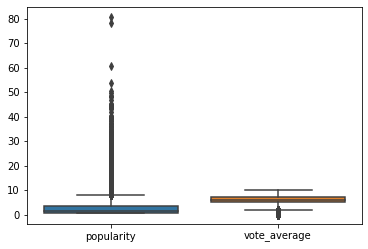

In [166]:

sns.boxplot(data=df_movies[['popularity','vote_average']])

In [167]:
df_movies[df_movies['popularity']>10] #1534 out of 25497

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73,2010-03-26,How to Train Your Dragon,7.70,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.52,2010-05-07,Iron Man 2,6.80,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.00,1995-11-22,Toy Story,7.90,10174
4,"[28, 878, 12]",27205,en,Inception,27.92,2010-07-16,Inception,8.30,22186
...,...,...,...,...,...,...,...,...,...
24167,"[16, 12, 14]",271706,zh,大魚海棠,10.04,2018-04-06,Big Fish & Begonia,7.50,154
24168,"[80, 18, 36, 53]",339103,en,Gotti,10.03,2018-06-15,Gotti,5.20,231
24170,"[53, 9648, 18, 27]",470229,en,Summer of 84,10.02,2018-08-10,Summer of 84,6.80,345
24171,"[28, 12, 27]",409582,en,Guardians of the Tomb,10.01,2018-02-23,Guardians of the Tomb,5.10,80


In [168]:
#remove outliers for popularity
Q1,Q3 = df_movies['popularity'].quantile([0.25,0.75])
IQR= Q3 - Q1

x = df_movies[((df_movies['popularity'] < (Q1 - 1.5 * IQR)) | (df_movies['popularity'] > (Q3 + 1.5 * IQR)))] 

In [169]:
df_movies

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.53,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.70,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.73,2010-03-26,How to Train Your Dragon,7.70,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.52,2010-05-07,Iron Man 2,6.80,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.00,1995-11-22,Toy Story,7.90,10174
4,"[28, 878, 12]",27205,en,Inception,27.92,2010-07-16,Inception,8.30,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.60,2018-10-13,Laboratory Conditions,0.00,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.60,2018-05-01,_EXHIBIT_84xxx_,0.00,1
26514,"[14, 28, 12]",381231,en,The Last One,0.60,2018-10-01,The Last One,0.00,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.60,2018-06-22,Trailer Made,0.00,1


### d)Convert data types

In [170]:
df_movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [171]:
df_movie_budget.head() #convert 'production_budget', 'domestic_gross','worldwide_gross' to float

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [172]:
cols = ['production_budget', 'domestic_gross','worldwide_gross']
df_movie_budget[cols] = df_movie_budget[cols].apply(lambda x: x.str.replace(',',''))
df_movie_budget[cols] = df_movie_budget[cols].apply(lambda x: x.str.strip('$')).astype(np.int64)

### OBJECTIVES: 1)Identify which genres are well performing both domestically and internationally

In [173]:
movies_budget_info = pd.merge(df_movie_info,df_movie_budget,on ='id', how='inner')
movies_budget_info.head()

,id,genre,runtime_minutes,studio,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,1,Action and Adventure|Classics|Drama,104,UNKOWN,"May 29, 2009",Up,175000000,293004164,731463377
2,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Mar 7, 2014",Mr. Peabody & Sherman,145000000,111506430,269806430
3,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 17, 2010",How Do You Know?,120000000,30212620,49628177
4,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 11, 2015",In the Heart of the Sea,100000000,25020758,89693309


In [174]:
movies_budget_info['main_genre'] = movies_budget_info['genre'].str.split('|').str[0]
movies_budget_info.head()

,id,genre,runtime_minutes,studio,release_date,movie,production_budget,domestic_gross,worldwide_gross,main_genre
0,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,Action and Adventure
1,1,Action and Adventure|Classics|Drama,104,UNKOWN,"May 29, 2009",Up,175000000,293004164,731463377,Action and Adventure
2,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Mar 7, 2014",Mr. Peabody & Sherman,145000000,111506430,269806430,Action and Adventure
3,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 17, 2010",How Do You Know?,120000000,30212620,49628177,Action and Adventure
4,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 11, 2015",In the Heart of the Sea,100000000,25020758,89693309,Action and Adventure


In [175]:
movies_budget_info['profit'] = movies_budget_info['domestic_gross'] + movies_budget_info['worldwide_gross'] -  movies_budget_info['production_budget']
movies_budget_info.head()

,id,genre,runtime_minutes,studio,release_date,movie,production_budget,domestic_gross,worldwide_gross,main_genre,profit
0,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,Action and Adventure,3111852904
1,1,Action and Adventure|Classics|Drama,104,UNKOWN,"May 29, 2009",Up,175000000,293004164,731463377,Action and Adventure,849467541
2,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Mar 7, 2014",Mr. Peabody & Sherman,145000000,111506430,269806430,Action and Adventure,236312860
3,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 17, 2010",How Do You Know?,120000000,30212620,49628177,Action and Adventure,-40159203
4,1,Action and Adventure|Classics|Drama,104,UNKOWN,"Dec 11, 2015",In the Heart of the Sea,100000000,25020758,89693309,Action and Adventure,14714067


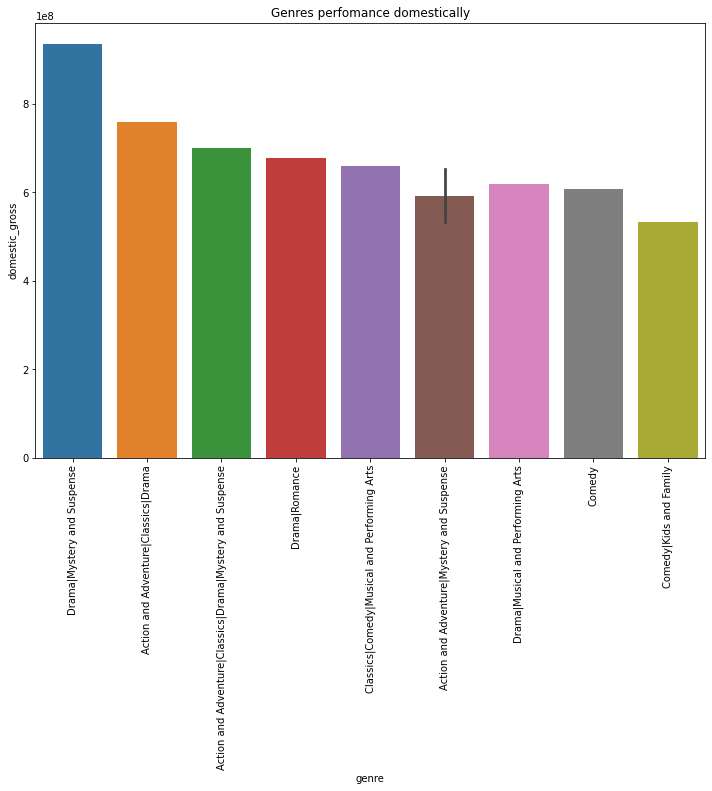

In [176]:
#genres domestically
fig, ax = plt.subplots(figsize=(12,8))
top_10_domestic = movies_budget_info.sort_values('domestic_gross',ascending=False).head(10)
sns.barplot(data = top_10_domestic,x = 'genre',y='domestic_gross')
plt.xticks(rotation=90)
plt.title('Genres perfomance domestically');

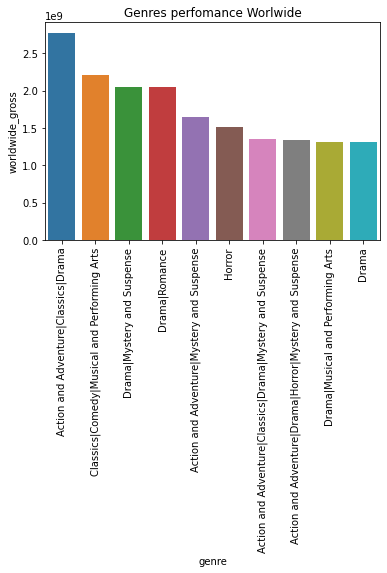

In [177]:
#genres foreign
top_10_foreign = movies_budget_info.sort_values('worldwide_gross',ascending=False).head(10)
sns.barplot(data = top_10_foreign,x = 'genre',y='worldwide_gross')
plt.xticks(rotation=90)
plt.title('Genres perfomance Worlwide');

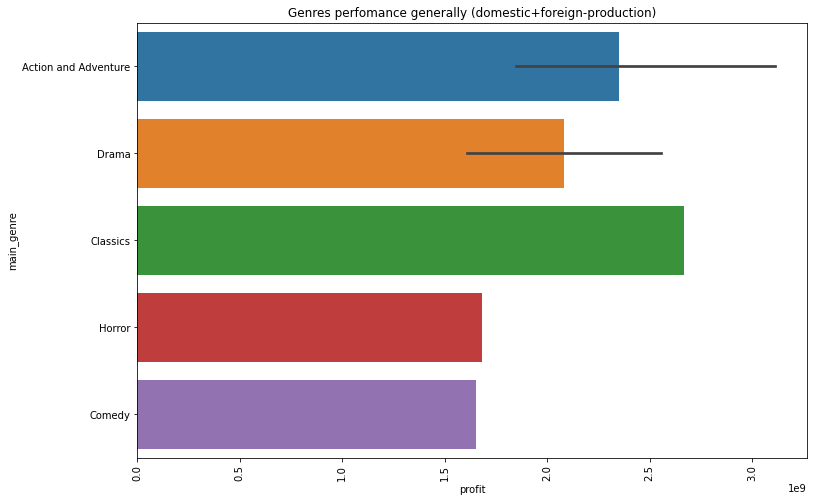

In [178]:
#genres with most returns i,e (domestic+foreign-production)
fig, ax = plt.subplots(figsize=(12,8))
top_10_profit = movies_budget_info.sort_values('profit',ascending=False).head(10)
sns.barplot(data = top_10_profit,x = 'profit',y='main_genre',orient='h')
plt.xticks(rotation=90)
plt.title('Genres perfomance generally (domestic+foreign-production)');

In [179]:
# performance = movies_budget_info.groupby(['genre'])['domestic_gross','worldwide_gross'].agg(
#     total_domestic = ('domestic_gross','sum'),
#     total_foreign = ('worldwide_gross','sum')
# ).reset_index()

In [180]:
# Rank generes based on gross and domestic performance
# performance['domestic_rank'] = performance['total_domestic'].rank(ascending=False)
# performance['foreign_rank'] = performance['total_foreign'].rank(ascending=False)

In [181]:
# top_10_domestic= performance.sort_values('total_domestic',ascending=False).head(10)

In [182]:
# fig, ax =plt.subplots(figsize=(12,8))
# sns.scatterplot(x='genre',y='total_domestic',data=top_10_domestic)
# plt.xticks(rotation=90);

In [183]:
# fig, ax =plt.subplots(figsize=(12,8))
# sns.scatterplot(x='',y='total_domestic',data=top_10_domestic)
# plt.xticks(rotation=90);

### 3.a) Analyze relationship between production budget and domestic and foreign gross

In [184]:
df_movie_gross.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.00,652000000.00,2010
1,Alice in Wonderland (2010),BV,334200000.00,691300000.00,2010


In [185]:
df_movie_budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


In [186]:
movie_gross_combined= pd.merge(df_movie_gross,df_movie_budget,left_on ='title',right_on='movie', how='inner')
movie_gross_combined

,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross
0,Toy Story 3,BV,415000000.00,652000000.00,2010,47,"Jun 18, 2010",Toy Story 3,200000000,415004880,1068879522
1,Inception,WB,292600000.00,535700000.00,2010,38,"Jul 16, 2010",Inception,160000000,292576195,835524642
2,Shrek Forever After,P/DW,238700000.00,513900000.00,2010,27,"May 21, 2010",Shrek Forever After,165000000,238736787,756244673
3,The Twilight Saga: Eclipse,Sum.,300500000.00,398000000.00,2010,53,"Jun 30, 2010",The Twilight Saga: Eclipse,68000000,300531751,706102828
4,Iron Man 2,Par.,312400000.00,311500000.00,2010,15,"May 7, 2010",Iron Man 2,170000000,312433331,621156389
...,...,...,...,...,...,...,...,...,...,...,...
1239,Gotti,VE,4300000.00,19400000.00,2018,64,"Jun 15, 2018",Gotti,10000000,4286367,6089100
1240,Ben is Back,RAtt.,3700000.00,19400000.00,2018,95,"Dec 7, 2018",Ben is Back,13000000,3703182,9633111
1241,Bilal: A New Breed of Hero,VE,491000.00,1700000.00,2018,100,"Feb 2, 2018",Bilal: A New Breed of Hero,30000000,490973,648599
1242,Mandy,RLJ,1200000.00,19400000.00,2018,71,"Sep 14, 2018",Mandy,6000000,1214525,1427656


In [187]:
#rename columns domestic_gross_x and domestic_gross_y
movie_gross_combined.rename(columns={
    'domestic_gross_x':'domestic_gross',
    'domestic_gross_y':'domestic_gross_budget',
    'worldwide_gross':'foreign_gross_budget'
},inplace=True)

In [188]:
movie_gross_combined.head(2)

,title,studio,domestic_gross,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_budget,foreign_gross_budget
0,Toy Story 3,BV,415000000.00,652000000.00,2010,47,"Jun 18, 2010",Toy Story 3,200000000,415004880,1068879522
1,Inception,WB,292600000.00,535700000.00,2010,38,"Jul 16, 2010",Inception,160000000,292576195,835524642


### Visualize relationship

Correlation between production budget and domestic gross: 0.7002831164328573
Correlation between production budget and foreign gross: 0.7590722931779372


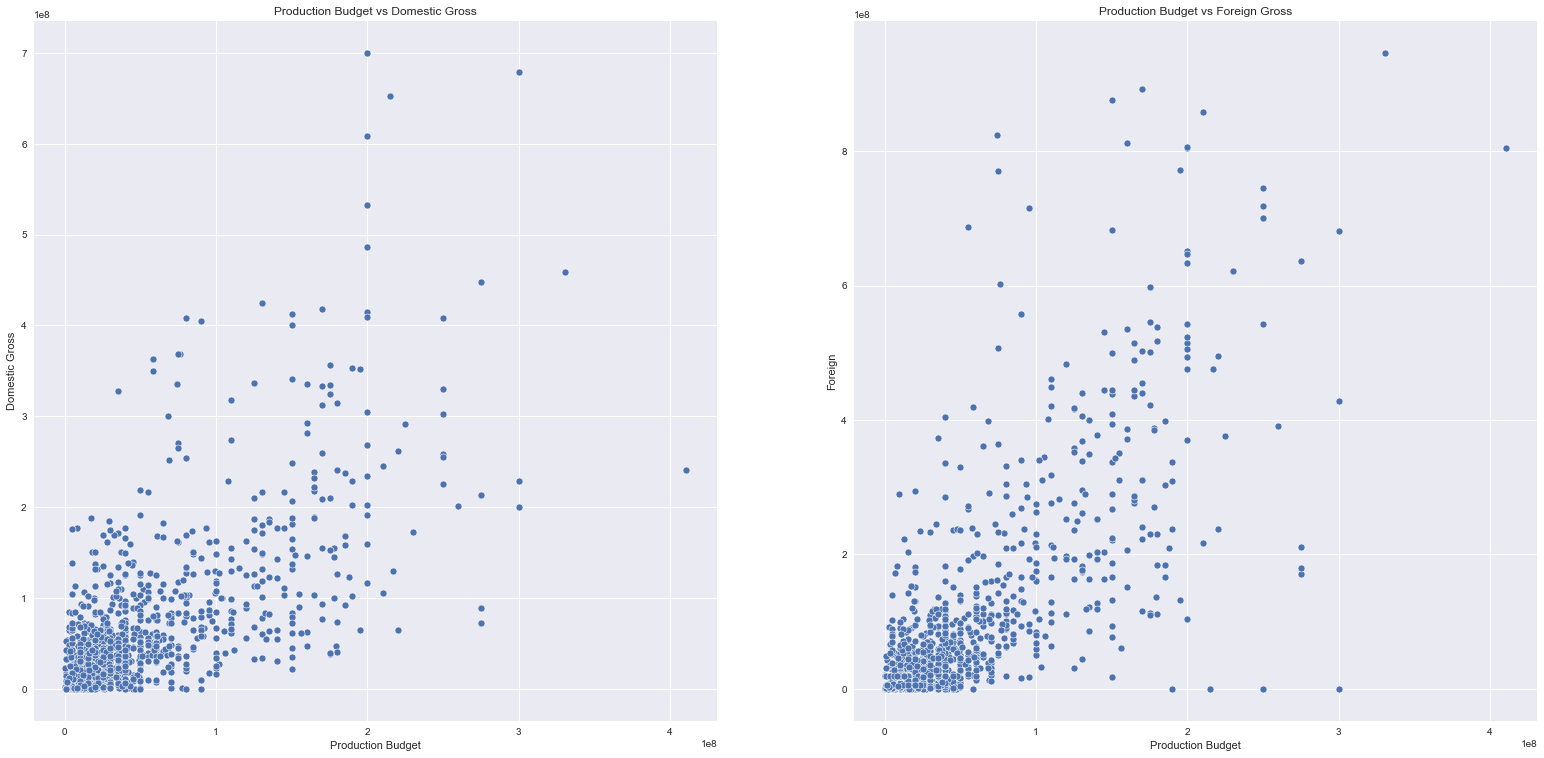

In [215]:
#scatterplot, production budget vs Domestic gross vs Foreign gross
plt.style.use('seaborn')
fig, ax = plt.subplots(ncols=2,figsize=(24,12))
sns.scatterplot(data=movie_gross_combined,x='production_budget',y='domestic_gross',ax=ax[0])
sns.scatterplot(data=movie_gross_combined,x='production_budget',y='foreign_gross',ax=ax[1])
ax[0].set(title = 'Production Budget vs Domestic Gross',xlabel='Production Budget',ylabel='Domestic Gross')
ax[1].set(title = 'Production Budget vs Foreign Gross',xlabel='Production Budget',ylabel='Foreign');
domestic_corr = np.corrcoef(movie_gross_combined['production_budget'],movie_gross_combined['domestic_gross'])[0][1]
foreign_corr = np.corrcoef(movie_gross_combined['production_budget'],movie_gross_combined['foreign_gross'])[0][1]
print(f"Correlation between production budget and domestic gross: {domestic_corr}")
print(f"Correlation between production budget and foreign gross: {foreign_corr}")

### CONCLUSION:
An `increase` in production budget is `positively associated with high revenue in both domestic and foreign markets`.However the foreign market shows a `slightly stronger` return on investment, with a correlation of 0.75 compared to 0.70 for the domestic market.This suggests that while both markets benefit from higher budgets, the `foreign market may yield greater` returns relative to production investment

### b)Check Return on investment for both domestic and foreign

In [217]:
movie_gross_combined['domestic_ROI'] = ((movie_gross_combined['domestic_gross']-movie_gross_combined['production_budget'])/movie_gross_combined['production_budget']) *100
movie_gross_combined['foreign_ROI'] = ((movie_gross_combined['foreign_gross'] -movie_gross_combined['production_budget'])/movie_gross_combined['production_budget']) *100

In [ ]:
#create column that stores the greater roi
movie_gross_combined['greater_roi'] = ['Domestic'  if d> f else 'Foreign' for d, f in  zip(movie_gross_combined['domestic_ROI'] ,movie_gross_combined['foreign_ROI'])] #for d, f in  zip(movie_gross_combined['domestic_ROI'] ,movie_gross_combined['foreign_ROI']):print(d,f)
movie_gross_combined

,title,studio,domestic_gross,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_budget,foreign_gross_budget,domestic_ROI,foreign_ROI,greater_roi
0,Toy Story 3,BV,415000000.00,652000000.00,2010,47,"Jun 18, 2010",Toy Story 3,200000000,415004880,1068879522,107.50,226.00,Foreign
1,Inception,WB,292600000.00,535700000.00,2010,38,"Jul 16, 2010",Inception,160000000,292576195,835524642,82.88,234.81,Foreign
2,Shrek Forever After,P/DW,238700000.00,513900000.00,2010,27,"May 21, 2010",Shrek Forever After,165000000,238736787,756244673,44.67,211.45,Foreign
3,The Twilight Saga: Eclipse,Sum.,300500000.00,398000000.00,2010,53,"Jun 30, 2010",The Twilight Saga: Eclipse,68000000,300531751,706102828,341.91,485.29,Foreign
4,Iron Man 2,Par.,312400000.00,311500000.00,2010,15,"May 7, 2010",Iron Man 2,170000000,312433331,621156389,83.76,83.24,Domestic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,Gotti,VE,4300000.00,19400000.00,2018,64,"Jun 15, 2018",Gotti,10000000,4286367,6089100,-57.00,94.00,Foreign
1240,Ben is Back,RAtt.,3700000.00,19400000.00,2018,95,"Dec 7, 2018",Ben is Back,13000000,3703182,9633111,-71.54,49.23,Foreign
1241,Bilal: A New Breed of Hero,VE,491000.00,1700000.00,2018,100,"Feb 2, 2018",Bilal: A New Breed of Hero,30000000,490973,648599,-98.36,-94.33,Foreign
1242,Mandy,RLJ,1200000.00,19400000.00,2018,71,"Sep 14, 2018",Mandy,6000000,1214525,1427656,-80.00,223.33,Foreign


In [ ]:
#get a count of how many movies have a higher domestic ROI versus foreign ROI
roi_comparison_count = movie_gross_combined['greater_roi'].value_counts()
roi_comparison_count

Foreign     753
Domestic    491
Name: greater_roi, dtype: int64

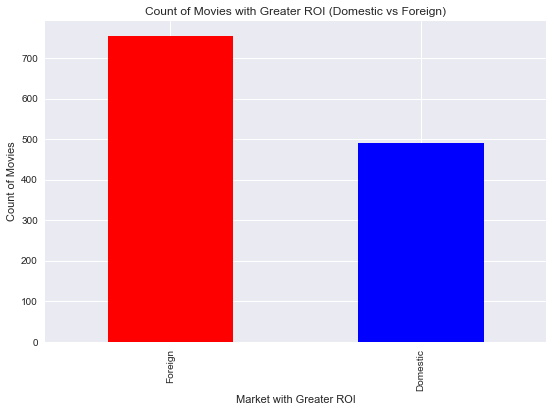

In [233]:
roi_comparison_count.plot(kind='bar',color=['red','blue'])
plt.xlabel('Market with Greater ROI')
plt.ylabel('Count of Movies')
plt.title('Count of Movies with Greater ROI (Domestic vs Foreign)');

### Foreign markets have a `greater return` on investmet that domestic markets

### c)Statisctical tests 
### TEST 1

**Null $H_{0}$**: `Production budget has no effect on the domestic gross`

$H_{0}: \mu_{productionbudget} = \mu_{domesticgross}$


**Alternative $H_1$**: `production budget has an effect on the domestic gross`

$H_1$: $\mu_{productionbudget} \neq \mu_{domesticgross}$


In [243]:
t_statistic,pvalue = stats.ttest_rel(movie_gross_combined['production_budget'],movie_gross_combined['domestic_gross'])
print('t_statistic',t_statistic)
print('pvalue',pvalue)

alpha = 0.05
#since this is one-tailed test we need to divide p-value by 2
if pvalue < alpha:
    print('Reject the null hypothesis (H₀): Production budget has an effect on domestic gross')
else:
    print('Fail to reject the null hypothesis(H₀):Production budget has no effect on domestic gross')

t_statistic -7.90029948992997
pvalue 6.085079260278646e-15
Reject the null hypothesis (H₀): Production budget has an effect on domestic gross


### TEST 2
**Null $H_{0}$**: `Production budget has no effect on the foreign gross`

$H_{0}: \mu_{productionbudget} = \mu_{domesticgross}$


**Alternative $H_1$**: `production budget has an effect on the foreign gross`

$H_1$: $\mu_{productionbudget} \neq \mu_{domesticgross}$

In [269]:
t_statistic,pvalue = stats.ttest_rel(movie_gross_combined['production_budget'],movie_gross_combined['foreign_gross'])
print('t_statistic',t_statistic)
print('pvalue',pvalue)

alpha = 0.05
#since this is one-tailed test we need to divide p-value by 2
if pvalue < alpha:
    print('Reject the null hypothesis (H₀): Production budget has an effect on foreign gross')
else:
    print('Fail to reject the null hypothesis(H₀):Production budget has no effect on foreign gross')
    

t_statistic -13.855819323330593
pvalue 1.0533892922318532e-40
Reject the null hypothesis (H₀): Production budget has an effect on foreign gross


### TEST 3
**Null $H_{0}$**: `Foreign markets and domestic markets have the same return on investment`

$H_{0}$: $\mu_{foreign}$ <= $\mu_{domestic}$


**Alternative $H_1$**: `foreign markets have greater returns on investment`

$H_1$: $\mu_{foreign}$ > $\mu_{domestic}$

In [264]:
t_statistic,pvalue = stats.ttest_rel(movie_gross_combined['domestic_ROI'],movie_gross_combined['foreign_ROI'])
print('t_statistic',t_statistic)
print('pvalue',pvalue)

alpha = 0.05
#since this is one-tailed test we need to divide p-value by 2
if pvalue/2 < alpha:
    print('Reject the null hypothesis (H₀): Foreign Markets have a greater returns on investment')
else:
    print('Fail to reject the null hypothesis(H₀):Foreign markets and domestic markets have the same return on investment')

t_statistic -3.6368589028654768
pvalue 0.0002872771247398666
Reject the null hypothesis (H₀): Foreign Markets have a greater returns on investment


### d)Modelling
### a)production budget vs domestic revenue

In [276]:
#Determining X and y variables
X = movie_gross_combined[['production_budget']]
y=  movie_gross_combined['domestic_gross']

#creating the model
model = sm.OLS(endog=y, exog=sm.add_constant(X))
#fit the model
results = model.fit()
results.params


c:\Users\Gmwende\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


const               10714593.32
production_budget          1.06
dtype: float64

### FINDING 1
### y = 1.06x + 10714593.32
This means that for a `production budget of 0` our model would predict about `10714593.32` in domestic gross revenue.An `increase of 1` in production budget is asscociated with an increase of about `1.06` in domestic revenue

In [274]:
# #check if our model is statistically significant
results.f_pvalue # our pvalue is below the p-alpha of 

5.017737620658228e-184

### Finding 2
`This means that our model is statisctically significant, with a p-value below the standard alpha of 0.05`

In [275]:
results.rsquared

0.4903964431609149

### Finding 3
Our model explais about `49.03%` of the variance in domestic revenues, the depedent variable. This is a poor fit

### b)production budget vs Foreign revenue

In [277]:
#Determining X and y variables
X = movie_gross_combined[['production_budget']]
y=  movie_gross_combined['foreign_gross']

#creating the model
model = sm.OLS(endog=y, exog=sm.add_constant(X))
#fit the model
results = model.fit()
results.params

c:\Users\Gmwende\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


const               -3112424.80
production_budget          1.98
dtype: float64

### FINDING 1
### y = 1.98x + -3112424.80
This means that for a `production budget of 0` our model would predict about `-3112424.80` in foreign gross revenue.An `increase of 1` in production budget is asscociated with an increase of about `1.98` in foreign revenue

In [278]:
results.f_pvalue

8.853042048924947e-234

### Finding 2
`This means that our model is statisctically significant, with a p-value below the standard alpha of 0.05`

In [279]:
results.rsquared

0.5761907462704126

### Finding 3
Our model explais about `57.62%` of the variance in foreign revenues, the depedent variable. 

In [281]:
results.pvalues

const               0.38
production_budget   0.00
dtype: float64